<a href="https://colab.research.google.com/github/Jenniebn/wordLevelTrans/blob/main/notebooks/EnZhEncoderDecoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import time
import copy
import json
import math
import torch
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as TF
from torch import nn, optim, tensor
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

In [ ]:
from google.colab import drive

# TODO 0: Mount your Google Drive; this allows the runtime environment to access your drive.
drive.mount('/content/gdrive')

# NOTE: Make sure your path does NOT include a '/' at the end!
base_dir = "/content/gdrive/MyDrive/"
sys.path.append(base_dir)
## END TODO

Mounted at /content/gdrive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Mar 12 07:15:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# 1. Load Datasets

In [ ]:
with open('../data/zh_embedding.pkl', 'rb') as file:
    zh_embedding = pickle.load(file)
    file.close()
with open('../data/vocab_zh.pkl', 'rb') as file:
    vocab_zh = pickle.load(file)
    file.close()
with open('../data/word_to_index_zh.pkl', 'rb') as file:
    word_to_index_zh = pickle.load(file)
    file.close()
with open('../data/idx_to_embed_zh.pkl', 'rb') as file:
    idx_to_embed_zh = pickle.load(file)
    file.close()
with open('../data/en_embedding.pkl', 'rb') as file:
    en_embedding = pickle.load(file)
    file.close()
with open('../data/vocab_en.pkl', 'rb') as file:
    vocab_en = pickle.load(file)
    file.close()
with open('../data/word_to_index_en.pkl', 'rb') as file:
    word_to_index_en = pickle.load(file)
    file.close()
with open('../data/idx_to_embed_en.pkl', 'rb') as file:
    idx_to_embed_en = pickle.load(file)
    file.close()

In [ ]:
vocab_en = list(word_to_index_en.keys())
vocab_size_en = len(vocab_en)
first10pairs = {k: word_to_index_en[k] for k in list(word_to_index_en)[:10]}
print("The first 10 words in the English vocabulary are:", first10pairs)
print("EN vocab size is", vocab_size_en)
print("The index for the English word 'cannot' is:", word_to_index_en["cannot"])

The first 10 words in the English vocabulary are: {'and': 0, 'of': 1, 'a': 2, 'in': 3, 'is': 4, 'to': 5, 'for': 6, 'that': 7, 's': 8, 'with': 9}
EN vocab size is 82615
The index for the English word 'cannot' is: 700


In [ ]:
vocab_zh = list(word_to_index_zh.keys())
vocab_size_zh = len(vocab_zh)
first10pairs = {k: word_to_index_zh[k] for k in list(word_to_index_zh)[:10]}
print("The first 10 words in the Chinese vocabulary are:", first10pairs)
print("ZH vocab size is", vocab_size_zh)
print("The index for the Chinese word '的' is:", word_to_index_zh['的'])

The first 10 words in the Chinese vocabulary are: {'的': 0, '了': 1, '在': 2, '是': 3, '和': 4, '有': 5, '章': 6, '就': 7, '第': 8, '也': 9}
ZH vocab size is 95685
The index for the Chinese word '的' is: 0


In [ ]:
# Load the golden set
with open('../data/lemmatized_golden_set.json', encoding="utf-8-sig") as in_file:
  # returns JSON object as a dictionary
    golden_set = json.load(in_file)

# Closing file
in_file.close()

first10pairs = {k: golden_set[k] for k in list(golden_set)[:10]}
print(first10pairs)
print(f"There are {len(golden_set)} translation pairs")

{'petard': ['作茧自缚', '以子之矛，攻子之盾', '吐丝自缚'], 'northeasterly': ['向东北的', '东北风'], 'relinquishment': ['放弃'], 'reader': ['读者'], 'thawed': ['融化'], 'improvised': ['自制', '即席'], 'webbed': ['有蹼的'], 'extolled': ['赞扬'], 'votive': ['奉献的', '还愿'], 'ardour': ['激情', '热忱']}
There are 37888 translation pairs


In [ ]:
# en_vocab_list is list of unique English words in golden set
gold_en_list = list(golden_set.keys())

# length of English vocabulary
gold_en_size = len(gold_en_list)
print("There are", gold_en_size, "unique English words in our golden set")

There are 37888 unique English words in our golden set


In [ ]:
# Load the partitioned golden set
with open('../data/partitioned_golden_set2.json', encoding="utf-8-sig") as in_file:
  # returns JSON object as a dictionary
    partitioned_golden_set = json.load(in_file)

# Closing file
in_file.close()

concrete_emotion_label = partitioned_golden_set['concrete']['emotion_label']
concrete_emotion_laden = partitioned_golden_set['concrete']['emotion_laden']
concrete_other = partitioned_golden_set['concrete']['other']
abstract_emotion_label = partitioned_golden_set['abstract']['emotion_label']
abstract_emotion_laden = partitioned_golden_set['abstract']['emotion_laden']
abstract_other = partitioned_golden_set['abstract']['other']
unknown_emotion_label = partitioned_golden_set['unknown_abstraction']['emotion_label']
unknown_emotion_laden = partitioned_golden_set['unknown_abstraction']['emotion_laden']
unknown_other = partitioned_golden_set['unknown_abstraction']['other']

# 2. Preprocess

In [ ]:
torch.manual_seed(4)
np.random.seed(4)
random.seed(4)

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

ModuleNotFoundError: No module named 'nltk'

In [ ]:
with open('data/training_data.pkl', 'rb') as file:

    # Call load method to deserialze
    training_data = pickle.load(file)
    file.close()
with open('data/validation_data.pkl', 'rb') as file:

    # Call load method to deserialze
    validation_data = pickle.load(file)
    file.close()
with open('data/testing_data.pkl', 'rb') as file:

    # Call load method to deserialze
    testing_data = pickle.load(file)
    file.close()

In [ ]:
print("There are", len(training_data['en_index']), "English training data,", len(validation_data['en_index']), "validation data and", len(testing_data['en_index']), "testing data")
print("There are", len(training_data['zh_index']), "Chinese training data,", len(validation_data['zh_index']), "validation data and", len(testing_data['zh_index']), "testing data")
print("Translation for {} is {}".format(training_data["en_index"][100][0], training_data["zh_index"][100][0]))

There are 21311 English training data, 2663 validation data and 2670 testing data
There are 21311 Chinese training data, 2663 validation data and 2670 testing data
Translation for camouflage is ('保护色', 59612)


In [ ]:
print(training_data["en_index"][:5])
print(training_data["zh_index"][:5])
print(validation_data["en_index"][:5])
print(validation_data["zh_index"][:5])
print(testing_data["en_index"][:5])
print(testing_data["zh_index"][:5])

[('down', 320), ('begging', 13203), ('abrasive', 13766), ('nappy', 32489), ('reading', 774)]
[[('下', 56), ('向下', 6010)], [('乞求', 28576), ('乞讨', 24497)], [('磨料', 38804)], [('尿布', 28039)], [('读', 2756), ('阅读', 550), ('读数', 22551)]]
[('ugly', 6705), ('tearful', 34041), ('caught', 3258), ('sour', 12134), ('lodging', 11589)]
[[('丑', 4810), ('丑恶', 31569)], [('含泪', 17889), ('沱', 62252)], [('陷入', 1879), ('陷于', 26914)], [('酸', 7516), ('酸甜苦辣', 23303), ('酸溜溜', 46638), ('酸味', 24089)], [('野营', 44250)]]
[('warm', 1785), ('stagnant', 19804), ('divided', 5625), ('blank', 2375), ('scarred', 25865)]
[[('暖和', 8933), ('温暖', 2248), ('温', 6249), ('暖', 7432)], [('死水', 43635)], [('更', 234)], [('白', 2044), ('呆', 6505), ('空白', 5902), ('空格', 15079)], [('疤', 22576)]]


# 3. Scheduler

In [ ]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

# 4. Custom Dataset

In [ ]:
# Define dataset to load to dataloader
class TrainData(Dataset):

    def __init__(self, data):
        """
        Loads the data in format
        data = {"en_index:..., zh_index:..."}
        en_list = [('petard', 67815), ('relinquishment', 50663),...]
        zh_list = [[('融化', 8830)], [('自制', 6059), ('即席', 82036)],...]
        """
        self.data    = data
        self.en_list = self.data["en_index"]
        self.zh_list = self.data["zh_index"]

    def __getitem__(self, idx):
        """Returns the datapoint at a given index"""
        en_index = self.en_list[idx][1]
        zh_onehot = torch.zeros(vocab_size_zh)
        for pair in self.zh_list[idx]:
            zh_onehot[pair[1]] = 1
        sample = {"en_index": en_index, "zh_index": zh_onehot}
        return sample

    def __len__(self):
        """Returns the number of datapoints in the dataset"""
        return len(self.data["en_index"])

In [ ]:
def collate_batch(batch):
    """Converts a batch of data into packed PyTorch tensor format
    """
    # Initialize lists that separate out the 3 components
    en_index_list  = list()
    zh_index_list  = list()

    for pair in batch:
        en_index = pair["en_index"]
        zh_index = pair["zh_index"]
        # Convert to PyTorch format
        # Add converted data to separate component lists
        en_index_list.append(en_index)
        zh_index_list.append(zh_index)

    # Convert to mini-batch tensors
    en_index_tensor = torch.tensor(en_index_list).to(torch.int64)
    zh_index_tensor = torch.stack(zh_index_list, dim=0).to(torch.int64)

    return (en_index_tensor, zh_index_tensor)

# 5. Create latent spaces + relative embeddings

In [ ]:
from typing import *
!pip install pytorch_lightning
from pytorch_lightning import seed_everything
from tqdm.auto import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 51.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
"""
This code is adopted from Moschella et al's work: https://github.com/lucmos/relreps?tab=readme-ov-file
"""
def relative_projection(x: torch.Tensor, anchors: torch.Tensor) -> torch.Tensor:
    """Compute the relative representation of x with the cosine similarity

    Args:
        x: the samples absolute latents [batch, hidden_dim]
        anchors: the anchors absolute latents [anchors, hidden_dim]

    Returns:
        the relative representation of x. The relative representation is *not* normalized,
        when training on relative representation it is useful to normalize it
    """
    x = TF.normalize(x, p=2, dim=-1)
    anchors = TF.normalize(anchors, p=2, dim=-1)
    return torch.einsum("bm, am -> ba", x, anchors)

class LatentSpace:
    def __init__(
        self,
        encoding_type: str,
        encoder_name: str,
        vectors: torch.Tensor,
        ids: Sequence[int],
    ):
        """Utility class to represent a generic latent space

        Args:
            encoding_type: the type of latent space, i.e. "absolute" or "relative" usually
            encoder_name: the name of the encoder used to obtain the vectors
            vectors: the latents that compose the latent space
            ids: the ids associated with the vectors
        """
        assert vectors.shape[0] == len(ids)

        self.encoding_type: str = encoding_type
        self.vectors: torch.Tensor = vectors
        self.ids: Sequence[int] = ids
        self.encoder_name: str = encoder_name

    def get_anchors(self, anchor_choice: str, num_anchors: int, seed: int) -> Sequence[int]:
        """Adopt some strategy to select the anchors.

        Args:
            anchor_choice: the selection strategy for the anchors
            seed: the random seed to use

        Returns:
            the ids of the chosen anchors
        """
        # Select anchors
        seed_everything(seed)
        anchor_set = []

        if anchor_choice == "uniform":
            while (len(anchor_set) != num_anchors):
              anchor_id = random.randint(0, len(self.ids))

              if anchor_id in anchor_set:
                # if the selected anchor is already in the set, pass
                continue
              elif anchor_id in en_index and anchor_id in zh_index:
                # if the selected anchor is in training set include it
                anchor_set.append(anchor_id)
              else:
                continue
        elif anchor_choice == "swadesh":
            for word in swadesh:
                anchor_id = word_to_index_en[word]
                anchor_set.append(anchor_id)
        else:
            assert NotImplementedError

        result = sorted(anchor_set)

        return result

    def to_relative(
        self, anchor_choice: str = None, seed: int = None, anchors: Optional[Sequence[int]] = None
    ) -> "RelativeSpace":
        """Compute the relative transformation on the current space returning a new one.

        Args:
            anchor_choice: the anchors selection strategy to use, if no anchors are provided
            seed: the random seed to use
            anchors: the ids of the anchors to use

        Returns:
            the RelativeSpace associated to the current LatentSpace
        """
        assert self.encoding_type != "relative"  # TODO: for now
        anchors = self.get_anchors(anchor_choice=anchor_choice, seed=seed) if anchors is None else anchors

        anchor_latents: torch.Tensor = self.vectors[anchors]

        relative_vectors = relative_projection(x=self.vectors, anchors=anchor_latents.cpu())

        return RelativeSpace(vectors=relative_vectors, encoder_name=self.encoder_name, anchors=anchors, ids=self.ids)

class RelativeSpace(LatentSpace):
    def __init__(
        self,
        vectors: torch.Tensor,
        ids: Sequence[int],
        anchors: Sequence[int],
        encoder_name: str = None,
    ):
        """Utility class to represent a relative latent space

        Args:
            vectors: the latents that compose the latent space
            ids: the ids associated ot the vectors
            encoder_name: the name of the encoder_name used to obtain the vectors
            anchors: the ids associated to the anchors to use
        """
        super().__init__(encoding_type="relative", vectors=vectors, encoder_name=encoder_name, ids=ids)
        self.anchors: Sequence[int] = anchors

# 6. Create latent space and relative embeddings using chosen anchors

In [ ]:
# Read dictionary to memory
def read_anchors(filePath):
    # for reading also binary mode is important
    with open(filePath, 'rb') as fp:
        n_list = json.load(fp)
        return n_list

r_anchors = read_anchors("gdrive/MyDrive/RelRep/data/anchors_random_dim_200.json")
print('Chosen English anchors are', r_anchors["en"])
print('Chosen Chinese anchors are', r_anchors["zh"])

Chosen English anchors are [197, 238, 253, 398, 549, 816, 823, 1077, 1099, 1103, 1112, 1233, 1363, 1400, 1509, 1521, 2060, 2064, 2083, 2246, 2392, 2416, 2497, 2553, 2595, 2605, 2794, 3081, 3127, 3160, 3164, 3172, 3203, 3245, 3321, 3597, 3608, 3657, 3673, 3981, 4038, 4117, 4177, 4398, 4417, 4458, 4753, 5002, 5125, 5278, 5357, 5472, 5896, 5999, 6141, 6367, 6717, 6871, 7021, 7054, 7203, 7676, 7914, 8085, 8265, 8297, 8469, 8577, 8860, 9327, 9436, 9640, 9671, 9879, 10056, 10136, 10143, 10460, 10484, 10552, 10671, 11050, 11124, 11257, 11350, 11494, 12048, 12576, 12859, 13017, 13167, 13235, 13259, 13357, 13375, 13380, 13493, 13666, 13764, 13815, 13820, 13888, 14668, 14982, 15525, 15649, 15960, 16597, 16716, 16875, 17262, 17405, 17744, 17876, 18037, 18071, 18100, 18349, 18404, 18638, 18852, 18986, 19088, 19202, 19784, 19827, 19842, 19846, 20113, 20449, 20645, 21126, 21285, 21701, 21900, 22337, 22375, 22528, 22628, 22693, 22767, 22908, 23777, 23837, 24578, 24625, 24658, 24844, 25182, 26162, 263

In [ ]:
# Double check number of anchors are equal in English and Chinese
assert len(r_anchors["en"]) == len(r_anchors["zh"])
NUM_ANCHORS = len(r_anchors["en"])
print("Number of anchors =", NUM_ANCHORS)

Number of anchors = 200


In [ ]:
NUM_SAMPLES_EN = vocab_size_en

en_anchors_ids = r_anchors["en"]
print("Selected English anchor ids are:", en_anchors_ids)

# Create English latent space from English absolute embeddings
en_abs_embedding = torch.FloatTensor(en_embedding)

en_abs_latent_space = LatentSpace(
    encoding_type="absolute",
    encoder_name="english abs embedding",
    vectors=en_abs_embedding,
    ids=list(range(NUM_SAMPLES_EN)),
)
print("En absolute embedding shape", en_abs_latent_space.vectors.shape)

en_rel_latent_space = en_abs_latent_space.to_relative(anchors=en_anchors_ids)
print("En relative embedding shape", en_rel_latent_space.vectors.shape)

Selected English anchor ids are: [197, 238, 253, 398, 549, 816, 823, 1077, 1099, 1103, 1112, 1233, 1363, 1400, 1509, 1521, 2060, 2064, 2083, 2246, 2392, 2416, 2497, 2553, 2595, 2605, 2794, 3081, 3127, 3160, 3164, 3172, 3203, 3245, 3321, 3597, 3608, 3657, 3673, 3981, 4038, 4117, 4177, 4398, 4417, 4458, 4753, 5002, 5125, 5278, 5357, 5472, 5896, 5999, 6141, 6367, 6717, 6871, 7021, 7054, 7203, 7676, 7914, 8085, 8265, 8297, 8469, 8577, 8860, 9327, 9436, 9640, 9671, 9879, 10056, 10136, 10143, 10460, 10484, 10552, 10671, 11050, 11124, 11257, 11350, 11494, 12048, 12576, 12859, 13017, 13167, 13235, 13259, 13357, 13375, 13380, 13493, 13666, 13764, 13815, 13820, 13888, 14668, 14982, 15525, 15649, 15960, 16597, 16716, 16875, 17262, 17405, 17744, 17876, 18037, 18071, 18100, 18349, 18404, 18638, 18852, 18986, 19088, 19202, 19784, 19827, 19842, 19846, 20113, 20449, 20645, 21126, 21285, 21701, 21900, 22337, 22375, 22528, 22628, 22693, 22767, 22908, 23777, 23837, 24578, 24625, 24658, 24844, 25182, 2616

In [ ]:
NUM_SAMPLES_ZH = vocab_size_zh

zh_anchors_ids = r_anchors["zh"]
print("Corresponding Chinese anchor ids are:", zh_anchors_ids)

zh_abs_embedding = torch.FloatTensor(zh_embedding)

zh_abs_latent_space = LatentSpace(
    encoding_type="absolute",
    encoder_name="chinese abs embedding",
    vectors=zh_abs_embedding,
    ids=list(range(NUM_SAMPLES_ZH)),
)

# The shape is [num_samples, hidden_dim]
print("Zh absolute embedding shape", zh_abs_latent_space.vectors.shape)

# Transform Chinese absolute latent space to relative latent space using the anchors chosen
zh_rel_latent_space = zh_abs_latent_space.to_relative(anchors=zh_anchors_ids)
print("Zh relative embedding shape", zh_rel_latent_space.vectors.shape)

Corresponding Chinese anchor ids are: [27, 117, 181, 241, 305, 369, 405, 663, 672, 697, 714, 765, 879, 950, 968, 1229, 1301, 1360, 1431, 1437, 1560, 1716, 1766, 1847, 1889, 1903, 2014, 2186, 2253, 2325, 2335, 2816, 2821, 2884, 2934, 2951, 2976, 3032, 3033, 3124, 3165, 3366, 3377, 3411, 3514, 3585, 3590, 3702, 3768, 3852, 3915, 3915, 3968, 4130, 4228, 4327, 4353, 4435, 4449, 4452, 4595, 4608, 4627, 4894, 5094, 5119, 5144, 5399, 5476, 5620, 5794, 5823, 5825, 5840, 6140, 6536, 6928, 7430, 7522, 7531, 7594, 7745, 7853, 7937, 8008, 8453, 8831, 9040, 9131, 9455, 9635, 10487, 10721, 10869, 11032, 11099, 11383, 11720, 11770, 11931, 12013, 12353, 12827, 13065, 13414, 13585, 14010, 14179, 14331, 14684, 14705, 14791, 14897, 14939, 15402, 16276, 16460, 17304, 17551, 17672, 17821, 17834, 18048, 18203, 18248, 18597, 18718, 18732, 18990, 19036, 19276, 19458, 19562, 19568, 19789, 19999, 20080, 20410, 20810, 20946, 21730, 21744, 22370, 22502, 22531, 23188, 23312, 23944, 25036, 25263, 25420, 25441, 2587

# 7. ZhRelAbs Model

In [ ]:
class ZhZhAutoencoderTW(nn.Module):
    """
    Autoencoder to learn the weights connecting Chinese
    embeddings back to one-hot vectors. Initialize the
    weights connecting the embeddings and one-hot vectors
    with the transpose of the weights from the Tecent
    pretrained model, connecting the one-hot vector and
    embedding, to speed up training.
    """
    def __init__(self, pretrained):
        super(ZhZhAutoencoderTW, self).__init__()

        # Save the pretrained embedding within the model
        # load pretrained embeddings and freeze them
        self.weights    = torch.FloatTensor(pretrained.vectors)
        self.encoder    = nn.Embedding.from_pretrained(self.weights, freeze = True)

        # Make a copy of the pretrained weights and use them in the following layers
        copy_pretrained = copy.deepcopy(pretrained)
        self.copyweight = torch.FloatTensor(copy_pretrained.vectors)
        self.decoder    = nn.Parameter(self.copyweight.t())

    def forward(self, text):
        """The pipeline that takes input values through the network"""
        # Find the embeddings for text
        trained_embed = self.encoder(text)

        # Turn embedding back to one-hot
        one_hot       = trained_embed @ self.decoder

        return one_hot

# 8. EnZh Autoencoder

In [ ]:
# Autoencoder to learn the weights connecting embeddings back to one-hot vectors
class EnZhAutoencoderHidden(nn.Module):

    def __init__(self, pretrained_en, pretrained_zh):
        super(EnZhAutoencoderHidden, self).__init__()

        # Save the pretrained English embedding from Tencent within the model
        # load pretrained embeddings and freeze them
        self.weights_en = torch.FloatTensor(pretrained_en.vectors)
        self.encoder    = nn.Embedding.from_pretrained(self.weights_en, freeze = True)

        # Load the pretrained weights from zhzhautoencoder
        # Use the pretrained weights to map Chinese embedding to one-hot
        # ***** use the tranpose!!!
        self.zh_weights = pretrained_zh
        self.decoder    = nn.Parameter(self.zh_weights, requires_grad=False)
        self.bias       = nn.Parameter(torch.FloatTensor(1, 1).uniform_(-1, 1))

        # Hidden layer definition
        self.hidden = nn.Sequential(
            nn.Linear(200, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 200)
        )

    def forward(self, text):
        """The pipeline that takes input values through the network"""
        # Find the English embedding
        eng_emb = self.encoder(text)
        # Pass the English embedding through hidden layer
        zh_emb  = self.hidden(eng_emb) # torch.Size([256, 100])
        # Find the corresponding index of Chinese word for
        # the English embedding decoder: torch.Size([100, 2000000])
        one_hot = zh_emb @ self.decoder
        return one_hot + self.bias

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
with open('../data/pos_weight.pkl', 'rb') as file:

    # A new file will be created
    pos_weight = pickle.load(file)
    file.close()

# for adjusting the high recall low precision
for i in range(len(pos_weight)):
    if (pos_weight[i] != 1):
        pos_weight[i] = pos_weight[i] * 0.02

In [ ]:
model_zhzh = ZhZhAutoencoderTW(zh_rel_latent_space).to(device)
state = torch.load('gdrive/MyDrive/RelRep/ckpt/zh_rel_to_abs_random_a200_e100-200_TEST.pt')
model_zhzh.load_state_dict(state['model_state_dict'])
model_zhzh_decoder = model_zhzh.decoder.clone()
model_enzh = EnZhAutoencoderHidden(en_rel_latent_space, model_zhzh_decoder).to(device)
optimizer = torch.optim.Adam(model_enzh.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

<ipython-input-28-c2282fd378e4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('gdrive/MyDrive/RelRep/ckpt/zh_rel_to_abs_random_a200_e100-200_TEST.pt')


# 9. Training

In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
with open('gdrive/MyDrive/RelRep/data/training_index_FINAL.pkl', 'rb') as file:

    # Call load method to deserialze
    training_index = set(pickle.load(file))
    file.close()
with open('gdrive/MyDrive/RelRep/data/validation_index_FINAL.pkl', 'rb') as file:

    # Call load method to deserialze
    validation_index = set(pickle.load(file))
    file.close()
with open('gdrive/MyDrive/RelRep/data/testing_index_FINAL.pkl', 'rb') as file:

    # Call load method to deserialze
    testing_index = set(pickle.load(file))
    file.close()

In [ ]:
train_data = TrainData(training_data)
valid_data = TrainData(validation_data)
test_data  = TrainData(testing_data)
print("Data format:", train_data[5])

Data format: {'en_index': 20197, 'zh_index': tensor([0., 0., 0.,  ..., 0., 0., 0.])}


In [ ]:
BATCH_SIZE = 512

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           collate_fn=collate_batch)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           collate_fn=collate_batch)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           collate_fn=collate_batch)

In [ ]:
# credit: https://gist.github.com/the-bass/cae9f3976866776dea17a5049013258d
def eval(prediction, truth, threshold=0.5):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """
    prediction = (prediction>=threshold).int()
    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)
    TP = torch.sum(confusion_vector == 1).item()
    FP = torch.sum(confusion_vector == float('inf')).item()
    FN = torch.sum(confusion_vector == 0).item()
    BATCH_MACRO = torch.stack((torch.sum(confusion_vector == 1, dim=0),
                               torch.sum(confusion_vector == float('inf'), dim=0),
                               torch.sum(confusion_vector == 0, dim=0)))

    # Jaccard metric
    jaccard = prediction.numpy()
    INDICES = set(np.where(jaccard==1)[1])
    return TP, FP, FN, BATCH_MACRO, INDICES

In [ ]:
def evalCalc(EPOCH_TP, EPOCH_FP, EPOCH_FN, EPOCH_MACRO, JACCARD, TYPE):
    evaluation = {}
    # Metric calc - micro
    if (EPOCH_FP+EPOCH_TP==0) or (EPOCH_FN+EPOCH_TP==0) or (EPOCH_TP==0):
        # handles edge case when model predicts everything negative
        precision_micro = "N/A"
        recall_micro    = "N/A"
        F1_micro        = "N/A"
    else:
        precision_micro = EPOCH_TP/(EPOCH_FP+EPOCH_TP)
        recall_micro    = EPOCH_TP/(EPOCH_FN+EPOCH_TP)
        F1_micro        = 2*precision_micro*recall_micro/(precision_micro+recall_micro)

    # Metric calc - macro
    precision = torch.div(EPOCH_MACRO[0], EPOCH_MACRO[0]+EPOCH_MACRO[1])
    precision[torch.isnan(precision)] = 0
    recall = torch.div(EPOCH_MACRO[0], EPOCH_MACRO[0]+EPOCH_MACRO[2])
    recall[torch.isnan(recall)] = 0
    if (torch.sum(precision)==0) or (torch.sum(recall)==0) or (torch.sum(EPOCH_MACRO[0])==0):
        # handles edge case when model predicts everything negative
        precision_macro = "N/A"
        recall_macro    = "N/A"
        F1_macro        = "N/A"
    else:
        precision_macro = torch.mean(precision).item()
        recall_macro    = torch.mean(recall).item()
        F1_macro        = 2*precision_macro*recall_macro/(precision_macro+recall_macro)

    # Jaccard metric
    if (TYPE == "training"):
        j_metric = float(len(JACCARD & training_index)) / float(len(JACCARD | training_index))
    elif (TYPE == "validation"):
        j_metric = float(len(JACCARD & validation_index)) / float(len(JACCARD | validation_index))
    elif (TYPE == "testing"):
        j_metric = float(len(JACCARD & testing_index)) / float(len(JACCARD | testing_index))

    evaluation["precision_micro"] = precision_micro
    evaluation["recall_micro"]    = recall_micro
    evaluation["F1_micro"]        = F1_micro
    evaluation["precision_macro"] = precision_macro
    evaluation["recall_macro"]    = recall_macro
    evaluation["F1_macro"]        = F1_macro
    evaluation["Jaccard"]         = j_metric
    return evaluation

In [ ]:
def train(model, train_history, modelFilePath, train_evalpath, valid_evalpath, jaccard_train_path,
        jaccard_valid_path, num_epochs, optimizer, criterion, batch_size, train_loader, valid_loader,
        base_lr, final_lr):

    train_loss = []
    train_eval = []
    valid_loss = []
    valid_eval = []
    jaccard_train = []
    jaccard_valid = []
    TYPE = "training"
    start = time.time()
    scheduler = CosineScheduler(max_update=num_epochs, base_lr=base_lr, final_lr=final_lr)
    print("Begin training...", file=open(train_history, 'a'))
    print("\n-----Batch Size =", batch_size, "NUM_ANCHORS =", NUM_ANCHORS, file=open(train_history, 'a'))

    for epoch in range(num_epochs):
        losses = 0
        correct = 0
        EPOCH_MACRO = torch.zeros((3, vocab_size_zh))
        EPOCH_TP = EPOCH_FP = EPOCH_FN = 0
        JACCARD = set()
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        print('\nEpoch: %d \nPercent Finished: %d%% Time Elapsed: %s' % (epoch, epoch / num_epochs * 100, timeSince(start)), file=open(train_history, 'a'))

        for batch_idx, (en_index, zh_index) in loop:
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Move inputs to cuda
            en_index = en_index.to(device)
            zh_index = zh_index.to(device)

            # Forward pass to get output/logits
            outputs_train = model(en_index)

            # Calculate Loss: BCE
            loss = criterion(outputs_train, zh_index.float())
            losses += loss.item()

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Evaluation
            BATCH_TP, BATCH_FP, BATCH_FN, BATCH_MACRO, INDICES = eval(outputs_train.sigmoid().cpu(), zh_index.cpu())
            EPOCH_TP += BATCH_TP
            EPOCH_FP += BATCH_FP
            EPOCH_FN += BATCH_FN
            EPOCH_MACRO += BATCH_MACRO
            JACCARD |= INDICES

            # Updating parameters
            optimizer.step()

            # update progress bar
            loop.set_description(f"Train Epoch: [{epoch}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        avg = losses / len(train_loader)
        train_loss.append(avg)
        train_eval.append(evalCalc(EPOCH_TP, EPOCH_FP, EPOCH_FN, EPOCH_MACRO, JACCARD, TYPE))
        jaccard_train.append(JACCARD)

        # Validate the model every 5 epochs
        if epoch % 5 == 0:
            v_loss, V_JACCARD, v_eval = validation(model, train_history)
            valid_loss.append(v_loss)
            valid_eval.append(v_eval)
            for key, value in v_eval.items():
                print("      Validation", key, ":", value, file=open(train_history, 'a'))
            print("      Finish validation!", file=open(train_history, 'a'))
            jaccard_valid.append(V_JACCARD)
            model.train()

        for param_group in optimizer.param_groups:
            param_group['lr'] = scheduler(epoch)
            print("   Learning rate:", param_group['lr'], file=open(train_history, 'a'))

        print("   Loss: {:.15f}".format(avg), file=open(train_history, 'a'))
        for key, value in train_eval[-1].items():
            print("   Training", key, ":", value, file=open(train_history, 'a'))

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'valid_loss': valid_loss,
                    'learning_rate': param_group['lr'],
                    'train_eval': train_eval,
                    'valid_eval': valid_eval,
                    'jaccard_train': jaccard_train,
                    'jaccard_valid': jaccard_valid
                    }, modelFilePath)

    with open(train_evalpath, 'wb') as file:
        pickle.dump(train_eval, file)
    with open(valid_evalpath, 'wb') as file:
        pickle.dump(valid_eval, file)
    with open(jaccard_train_path, 'wb') as file:
        pickle.dump(jaccard_train, file)
    with open(jaccard_valid_path, 'wb') as file:
        pickle.dump(jaccard_valid, file)
    print("Finish training!", file=open(train_history, 'a'))
    return train_loss, valid_loss

def validation(model, train_history):
    print("      Begin validation...", file=open(train_history, 'a'))

    model.eval()
    with torch.no_grad():
        losses = 0
        correct = 0
        EPOCH_TP = EPOCH_FP = EPOCH_FN = 0
        JACCARD = set()
        TYPE = "validation"
        EPOCH_MACRO = torch.zeros((3, vocab_size_zh))
        # Iterate through validation dataset
        loop = tqdm(enumerate(valid_loader), total=len(valid_loader), leave=False)
        for batch_idx, (en_index, zh_index) in loop:

            # Move inputs & outputs to cuda
            en_index = en_index.to(device)
            zh_index = zh_index.to(device)

            # Forward pass to get output/logits
            outputs_train = model(en_index)

            # Calculate Loss: BCE
            loss = criterion(outputs_train, zh_index.float())
            losses += loss.item()

            # Evaluation
            BATCH_TP, BATCH_FP, BATCH_FN, BATCH_MACRO, INDICES = eval(outputs_train.sigmoid().cpu(), zh_index.cpu())
            EPOCH_TP += BATCH_TP
            EPOCH_FP += BATCH_FP
            EPOCH_FN += BATCH_FN
            EPOCH_MACRO += BATCH_MACRO
            JACCARD |= INDICES

            # update progress bar
            loop.set_description(f"Validation Batch: [{batch_idx}/{len(valid_loader)}]")
            loop.set_postfix(loss=loss.item())

        train_loss = losses / len(valid_loader)

        # Print loss
        print("      Loss: {:.15f}".format(train_loss), file=open(train_history, 'a'))
        return train_loss, JACCARD, evalCalc(EPOCH_TP, EPOCH_FP, EPOCH_FN, EPOCH_MACRO, JACCARD, TYPE)

In [ ]:
os.makedirs("record", exist_ok=True)
os.makedirs("ckpt", exist_ok=True)

In [ ]:
NUM_EPOCH = 100

train_loss, valid_loss = train(model_enzh,
                                'gdrive/MyDrive/RelRep/record/EnZhEncoderDecoder.txt',
                                'gdrive/MyDrive/RelRep/ckpt/EnZhEncoderDecoder.pt',
                                'gdrive/MyDrive/RelRep/record/EnZhEncoderDecoder_train_eval.pkl',
                                'gdrive/MyDrive/RelRep/record/EnZhEncoderDecoder_valid_eval.pkl',
                                'gdrive/MyDrive/RelRep/record/EnZhEncoderDecoder_jaccard_train.pkl',
                                'gdrive/MyDrive/RelRep/record/EnZhEncoderDecoder_jaccard_valid.pkl',
                                NUM_EPOCH,
                                optimizer,
                                criterion,
                                BATCH_SIZE,
                                train_loader,
                                valid_loader,
                                base_lr=0.01,
                                final_lr=0.0001)

import pickle
with open('gdrive/MyDrive/RelRep/record/enzh_train_loss.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(train_loss, file)
with open('gdrive/MyDrive/RelRep/record/enzh_valid_loss.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(valid_loss, file)

In [ ]:
with open('gdrive/MyDrive/RelRep/record/EnZhEncoderDecoder_train_eval.pkl', 'rb') as file:
    train_eval = pickle.load(file)
    file.close()

with open('gdrive/MyDrive/RelRep/record/EnZhEncoderDecoder_valid_eval.pkl', 'rb') as file:
    valid_eval = pickle.load(file)
    file.close()

with open('gdrive/MyDrive/RelRep/record/EnZhEncoderDecoder_jaccard_train.pkl', 'rb') as file:
    jaccard_train = pickle.load(file)
    file.close()

with open('gdrive/MyDrive/RelRep/record/EnZhEncoderDecoder_jaccard_valid.pkl', 'rb') as file:
    jaccard_valid = pickle.load(file)
    file.close()

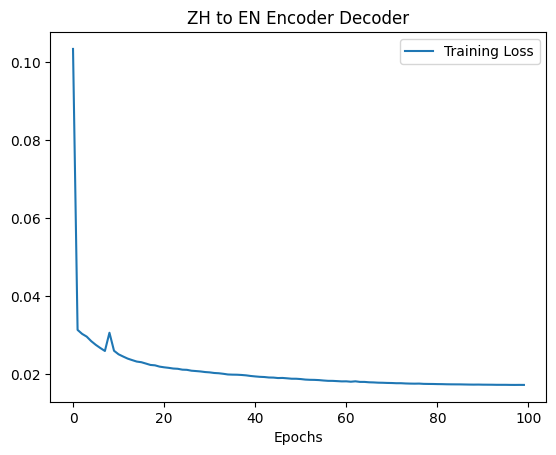

In [ ]:
xtrain = np.arange(100)
plt.plot(xtrain, train_loss, label = "Training Loss")
plt.xlabel("Epochs")
plt.title("ZH to EN Encoder Decoder")
plt.legend()

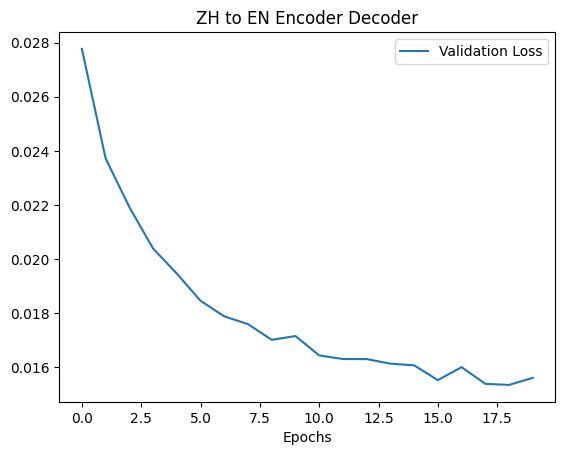

In [ ]:
xtrain = np.arange(20)
plt.plot(xtrain, valid_loss, label = "Validation Loss")
plt.xlabel("Epochs")
plt.title("ZH to EN Encoder Decoder")
plt.legend()

In [ ]:
train_precision_micro = []
train_recall_micro = []
train_f1_micro = []
train_precision_macro = []
train_recall_macro = []
train_f1_macro = []
train_jaccard = []

for index in range(len(train_eval)):
    train_precision_micro.append(train_eval[index]["precision_micro"])
    train_recall_micro.append(train_eval[index]["recall_micro"])
    train_f1_micro.append(train_eval[index]["F1_micro"])
    train_precision_macro.append(train_eval[index]["precision_macro"])
    train_recall_macro.append(train_eval[index]["recall_macro"])
    train_f1_macro.append(train_eval[index]["F1_macro"])
    train_jaccard.append(train_eval[index]["Jaccard"])

In [ ]:
train_precision_micro = [0 if x == 'N/A' else x for x in train_precision_micro]
train_recall_micro = [0 if x == 'N/A' else x for x in train_recall_micro]
train_f1_micro = [0 if x == 'N/A' else x for x in train_f1_micro]
train_precision_macro = [0 if x == 'N/A' else x for x in train_precision_macro]
train_recall_macro = [0 if x == 'N/A' else x for x in train_recall_macro]
train_f1_macro = [0 if x == 'N/A' else x for x in train_f1_macro]

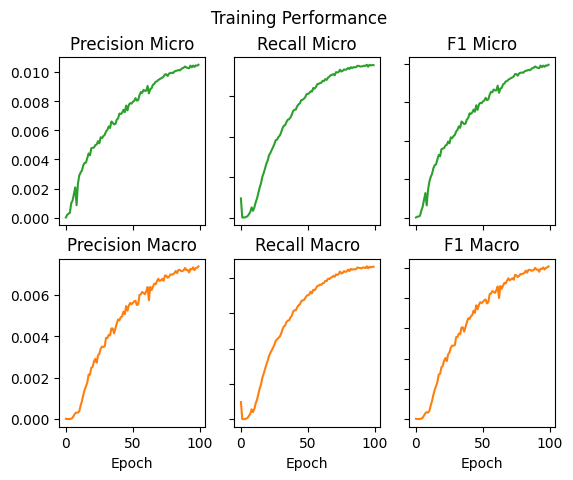

In [ ]:
xtrain = np.arange(100)
fig, axs = plt.subplots(2, 3)
fig.suptitle('Training Performance')
axs[0, 0].plot(xtrain, train_precision_micro, 'tab:green')
axs[0, 0].set_title("Precision Micro")
axs[0, 1].plot(xtrain, train_recall_micro, 'tab:green')
axs[0, 1].set_title("Recall Micro")
axs[0, 2].plot(xtrain, train_f1_micro, 'tab:green')
axs[0, 2].set_title("F1 Micro")
axs[1, 0].plot(xtrain, train_precision_macro, 'tab:orange')
axs[1, 0].set_title("Precision Macro")
axs[1, 1].plot(xtrain, train_recall_macro, 'tab:orange')
axs[1, 1].set_title("Recall Macro")
axs[1, 2].plot(xtrain, train_f1_macro, 'tab:orange')
axs[1, 2].set_title("F1 Macro")

for ax in axs.flat:
    ax.set(xlabel='Epoch')

for ax in fig.get_axes():
    ax.label_outer()

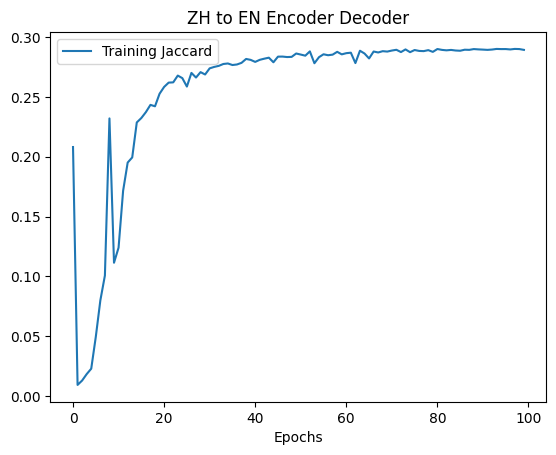

In [ ]:
xtrain = np.arange(100)
plt.plot(xtrain, train_jaccard, label = "Training Jaccard")
plt.xlabel("Epochs")
plt.title("ZH to EN Encoder Decoder")
plt.legend()

In [ ]:
valid_precision_micro = []
valid_recall_micro = []
valid_f1_micro = []
valid_precision_macro = []
valid_recall_macro = []
valid_f1_macro = []
valid_jaccard = []

for index in range(len(valid_eval)):
    valid_precision_micro.append(valid_eval[index]["precision_micro"])
    valid_recall_micro.append(valid_eval[index]["recall_micro"])
    valid_f1_micro.append(valid_eval[index]["F1_micro"])
    valid_precision_macro.append(valid_eval[index]["precision_macro"])
    valid_recall_macro.append(valid_eval[index]["recall_macro"])
    valid_f1_macro.append(valid_eval[index]["F1_macro"])
    valid_jaccard.append(valid_eval[index]["Jaccard"])

In [ ]:
valid_precision_micro = [0 if x == 'N/A' else x for x in valid_precision_micro]
valid_recall_micro = [0 if x == 'N/A' else x for x in valid_recall_micro]
valid_f1_micro = [0 if x == 'N/A' else x for x in valid_f1_micro]
valid_precision_macro = [0 if x == 'N/A' else x for x in valid_precision_macro]
valid_recall_macro = [0 if x == 'N/A' else x for x in valid_recall_macro]
valid_f1_macro = [0 if x == 'N/A' else x for x in valid_f1_macro]

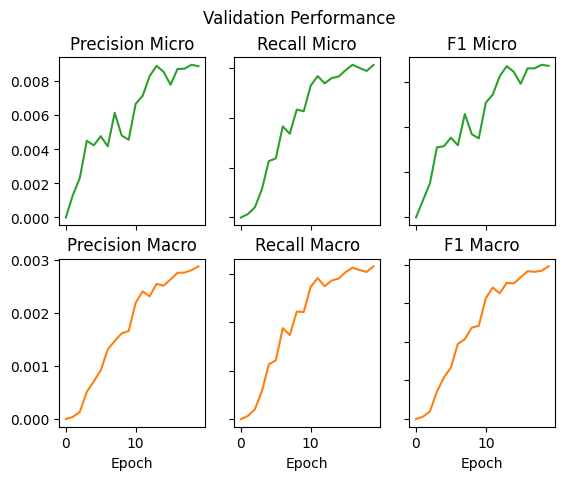

In [ ]:
xtrain = np.arange(20)
fig, axs = plt.subplots(2, 3)
fig.suptitle('Validation Performance')
axs[0, 0].plot(xtrain, valid_precision_micro, 'tab:green')
axs[0, 0].set_title("Precision Micro")
axs[0, 1].plot(xtrain, valid_recall_micro, 'tab:green')
axs[0, 1].set_title("Recall Micro")
axs[0, 2].plot(xtrain, valid_f1_micro, 'tab:green')
axs[0, 2].set_title("F1 Micro")
axs[1, 0].plot(xtrain, valid_precision_macro, 'tab:orange')
axs[1, 0].set_title("Precision Macro")
axs[1, 1].plot(xtrain, valid_recall_macro, 'tab:orange')
axs[1, 1].set_title("Recall Macro")
axs[1, 2].plot(xtrain, valid_f1_macro, 'tab:orange')
axs[1, 2].set_title("F1 Macro")

for ax in axs.flat:
    ax.set(xlabel='Epoch')

for ax in fig.get_axes():
    ax.label_outer()

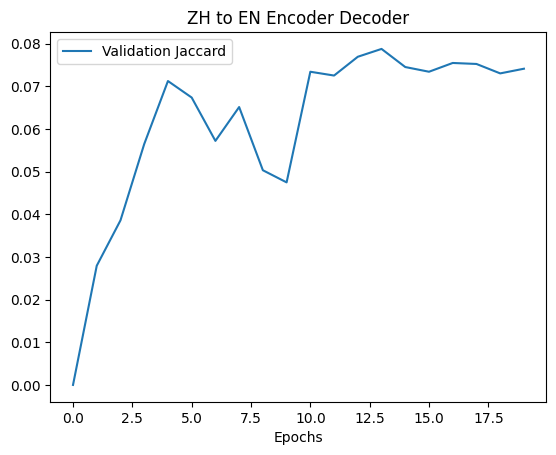

In [ ]:
plt.plot(xtrain, valid_jaccard, label = "Validation Jaccard")
plt.xlabel("Epochs")
plt.title("ZH to EN Encoder Decoder")
plt.legend()

# Evaluation

In [ ]:
def evaluation(model, testing_history):
    print("Begin testing...", file=open(testing_history, 'a'))

    model.eval()
    with torch.no_grad():
        losses = 0
        correct = 0
        EPOCH_TP = EPOCH_FP = EPOCH_FN = 0
        JACCARD = set()
        TYPE = "testing"
        EPOCH_MACRO = torch.zeros((3, vocab_size_zh))
        # Iterate through testing dataset
        loop = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
        for batch_idx, (en_index, zh_index) in loop:

            # Move inputs & outputs to cuda
            en_index = en_index.to(device)
            zh_index = zh_index.to(device)

            # Forward pass to get output/logits
            outputs_train = model(en_index)

            # Calculate Loss: BCE
            loss = criterion(outputs_train, zh_index.float())
            losses += loss.item()

            # Evaluation
            BATCH_TP, BATCH_FP, BATCH_FN, BATCH_MACRO, INDICES = eval(outputs_train.sigmoid().cpu(), zh_index.cpu())
            EPOCH_TP += BATCH_TP
            EPOCH_FP += BATCH_FP
            EPOCH_FN += BATCH_FN
            EPOCH_MACRO += BATCH_MACRO
            JACCARD |= INDICES

            # update progress bar
            loop.set_description(f"Testing Batch: [{batch_idx}/{len(test_loader)}]")
            loop.set_postfix(loss=loss.item())

        test_loss = losses / len(test_loader)
        test_eval = evalCalc(EPOCH_TP, EPOCH_FP, EPOCH_FN, EPOCH_MACRO, JACCARD, TYPE)

        # Print loss
        print("Loss: {:.15f}".format(test_loss), file=open(testing_history, 'a'))
        for key, value in test_eval.items():
            print("   Testing", key, ":", value, file=open(testing_history, 'a'))
        print("Finish testing!", file=open(testing_history, 'a'))

        return test_loss, JACCARD, test_eval

In [ ]:
zhzh_relrep = ZhZhAutoencoderTW(zh_rel_latent_space).to(device)
state = torch.load('gdrive/MyDrive/RelRep/ckpt/zh_rel_to_abs_random_a200_e100-200_TEST.pt')
zhzh_relrep.load_state_dict(state['model_state_dict'])
model_zhzh_decoder = zhzh_relrep.decoder.clone()
model_enzh = EnZhAutoencoderHidden(en_rel_latent_space, model_zhzh_decoder).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

<ipython-input-45-fdd884f978e2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('gdrive/MyDrive/RelRep/ckpt/zh_rel_to_abs_random_a200_e100-200_TEST.pt')


In [ ]:
state = torch.load('gdrive/MyDrive/RelRep/ckpt/EnZhAuto_hidden_a200_e0-100_01_18_2025_pw0.008.pt')
model_enzh.load_state_dict(state['model_state_dict'])

<ipython-input-46-3407f8b373ea>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('gdrive/MyDrive/RelRep/ckpt/EnZhAuto_hidden_a200_e0-100_01_18_2025_pw0.00

<All keys matched successfully>

In [ ]:
test_loss, test_JACCARD, test_eval = evaluation(model_enzh, 'gdrive/MyDrive/RelRep/record/EnZhAuto_hidden_pw0.02.txt')

import pickle
with open('gdrive/MyDrive/RelRep/record/enzh_test_loss_random_a200_hidden_pw0.02.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(test_loss, file)
with open('gdrive/MyDrive/RelRep/record/enzh_test_JACCARD_a200_hidden_pw0.02.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(test_JACCARD, file)
with open('gdrive/MyDrive/RelRep/record/enzh_test_eval_a200_hidden_pw0.02.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(test_eval, file)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# old enzh_test_loss_random_a200_hidden.pkl
with open('gdrive/MyDrive/RelRep/record/enzh_test_loss_random_a200_hidden.pkl', 'rb') as file:

    # Call load method to deserialze
    test_loss = pickle.load(file)
    file.close()

with open('gdrive/MyDrive/RelRep/record/enzh_test_JACCARD_a200_hidden.pkl', 'rb') as file:

    # A new file will be created
    test_JACCARD = pickle.load(file)
    file.close()

with open('gdrive/MyDrive/RelRep/record/enzh_test_eval_a200_hidden.pkl', 'rb') as file:

    # A new file will be created
    test_eval = pickle.load(file)
    file.close()

In [ ]:
for key, value in test_eval.items():
    print("Testing", key, ":", value)

Testing precision_micro : 0.008776303979256009
Testing recall_micro : 0.14073566369659585
Testing F1_micro : 0.016522275567953222
Testing precision_macro : 0.0026014242321252823
Testing recall_macro : 0.005916113965213299
Testing F1_macro : 0.00361379588152116
Testing Jaccard : 0.07458868157558114


In [ ]:
# new enzh_test_loss_random_a200_hidden.pkl
with open('gdrive/MyDrive/RelRep/record/enzh_test_loss_random_a200_hidden.pkl', 'rb') as file:

    # Call load method to deserialze
    test_loss = pickle.load(file)
    file.close()

with open('gdrive/MyDrive/RelRep/record/enzh_test_JACCARD_a200_hidden.pkl', 'rb') as file:

    # A new file will be created
    test_JACCARD = pickle.load(file)
    file.close()

with open('gdrive/MyDrive/RelRep/record/enzh_test_eval_a200_hidden.pkl', 'rb') as file:

    # A new file will be created
    test_eval = pickle.load(file)
    file.close()

In [ ]:
for key, value in test_eval.items():
    print("Testing", key, ":", value)

Testing precision_micro : 0.00048704506594138774
Testing recall_micro : 0.7769149311683727
Testing F1_micro : 0.0009734798609971599
Testing precision_macro : 0.0003899664443451911
Testing recall_macro : 0.03974238410592079
Testing F1_macro : 0.0007723542731530363
Testing Jaccard : 0.05343803241448604


# See translations

In [ ]:
BATCH_SIZE = 1

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           collate_fn=collate_batch)

In [ ]:
def translate(model, translation_history):
    print("Begin translating...", file=open(translation_history, 'a'))

    model.eval()
    with torch.no_grad():
        total_acc = 0
        total_jac = 0
        total = 0
        concrete_dict = {}
        c_elabel_list = []
        c_eladen_list = []
        c_other_list  = []
        abstract_dict = {}
        a_elabel_list = []
        a_eladen_list = []
        a_other_list  = []
        unknown_dict  = {}
        u_elabel_list = []
        u_eladen_list = []
        u_other_list  = []
        model_pred_cor = {}
        model_pred_wro = {}
        model_pred = {}
        model_comp = {}
        trans_stat = {}

        loop = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
        for batch_idx, (en_index, zh_index) in loop:

            # Move inputs & outputs to cuda
            en_index = en_index.to(device)
            zh_index = zh_index[0]

            # Forward pass to get output/logits
            outputs_train = model(en_index)

            # Top probability translations
            en_index = en_index.cpu()
            en_word  = vocab_en[en_index]
            correct_trans = golden_set[en_word]
            prob  = outputs_train.sigmoid().detach().cpu()
            idx   = list(torch.topk(prob[0], k=len(correct_trans))[1].numpy())
            model_trans = [vocab_zh[i] for i in idx]
            print(vocab_en[en_index] + "\n    model translation:"+ ", ".join(model_trans) + "\n    correct translation:"+ ", ".join(correct_trans), file=open(translation_history, 'a'))

            # Calculate accuracy & check class
            zh_onehot = torch.zeros(vocab_size_zh).int()
            for i in idx:
                zh_onehot[i] = 1
            correct = (zh_onehot & zh_index).sum()
            accuracy = correct/len(correct_trans)
            total_acc += accuracy
            if (accuracy > 0):
                if (en_word in concrete_emotion_label):
                    c_elabel_list.append(en_word)
                elif (en_word in concrete_emotion_laden):
                    c_eladen_list.append(en_word)
                elif (en_word in concrete_other):
                    c_other_list.append(en_word)
                elif (en_word in abstract_emotion_label):
                    a_elabel_list.append(en_word)
                elif (en_word in abstract_emotion_laden):
                    a_eladen_list.append(en_word)
                elif (en_word in abstract_other):
                    a_other_list.append(en_word)
                elif (en_word in unknown_emotion_label):
                    u_elabel_list.append(en_word)
                elif (en_word in unknown_emotion_laden):
                    u_eladen_list.append(en_word)
                elif (en_word in unknown_other):
                    u_other_list.append(en_word)
                model_pred_cor[en_word] = model_trans
            else:
                model_pred_wro[en_word] = model_trans

            # Calculate Jaccard
            correct_idx = list(zh_index.nonzero().flatten().detach().numpy())
            jaccard = float(len(set(idx) & set(correct_idx))) / float(len(set(idx) | set(correct_idx)))
            total_jac += jaccard

            # update progress bar
            loop.set_description(f"Translation Progress: [{batch_idx}/{len(test_loader)}]")
            loop.set_postfix(accuracy=accuracy.item())

        # Print accuracy
        avg_accuracy = total_acc/len(testing_data["en_index"])*100
        avg_jaccard = total_jac/len(testing_data["en_index"])
        trans_stat["avg_accuracy"] = avg_accuracy
        trans_stat["avg_jaccard"] = avg_jaccard
        concrete_dict['emotion_label'] = c_elabel_list
        concrete_dict['emotion_laden'] = c_eladen_list
        concrete_dict['other'] = c_other_list
        abstract_dict['emotion_label'] = a_elabel_list
        abstract_dict['emotion_laden'] = a_eladen_list
        abstract_dict['other'] = a_other_list
        unknown_dict['emotion_label'] = u_elabel_list
        unknown_dict['emotion_laden'] = u_eladen_list
        unknown_dict['other'] = u_other_list
        model_comp["concrete"] = concrete_dict
        model_comp["abstract"] = abstract_dict
        model_comp["unknown_abstraction"] = unknown_dict
        model_pred["correct"] = model_pred_cor
        model_pred["wrong"] = model_pred_wro
        print("Average Accuracy: {:.2f}%\nAverage Jaccard: {:.2f}".format(avg_accuracy, avg_jaccard), file=open(translation_history, 'a'))
        print("Average Accuracy: {:.2f}%\nAverage Jaccard: {:.2f}".format(avg_accuracy, avg_jaccard))
        print("Finish translating!", file=open(translation_history, 'a'))

        import pickle
        with open('gdrive/MyDrive/RelRep/record/enzh_trans_stat_612.pkl', 'wb') as file:

            # A new file will be created
            pickle.dump(trans_stat, file)
        with open('gdrive/MyDrive/RelRep/record/enzh_model_composition_612.pkl', 'wb') as file:

            # A new file will be created
            pickle.dump(model_comp, file)
        with open('gdrive/MyDrive/RelRep/record/enzh_model_prediction_612.pkl', 'wb') as file:

            # A new file will be created
            pickle.dump(model_pred, file)
        return trans_stat, model_comp, model_pred

In [ ]:
trans_stat, model_comp, model_pred = translate(model_enzh, 'gdrive/MyDrive/RelRep/record/EnZhAuto_hidden_translation_612.txt')

  0%|          | 0/2670 [00:00<?, ?it/s]

Average Accuracy: 2.85%
Average Jaccard: 0.02


In [ ]:
for key, value in model_comp.items():
    print(key, ":", value)

concrete : {'emotion_label': ['warm'], 'emotion_laden': ['secrete', 'radar', 'cafe', 'prostitution', 'soot', 'nectar', 'leak', 'archaeology', 'chisel', 'ransom', 'bouquet', 'torture', 'operation', 'mentor', 'loudness', 'learning', 'weeping', 'detonation', 'cremation', 'opaque', 'baboon', 'measles', 'janitor', 'locust', 'ribbon', 'obese', 'maroon'], 'other': ['encoder', 'snoring', 'deep', 'sit', 'genetics', 'tinfoil', 'breaststroke', 'performance', 'ozone', 'petrol', 'transport', 'coitus', 'currency', 'shut', 'masticate', 'rough', 'tanker', 'translator', 'pictograph', 'certificate', 'torque', 'kidnapper', 'digging', 'bright', 'limestone', 'bag', 'wharf', 'pecked', 'beeswax', 'notarize', 'coarse', 'bedridden', 'greasiness', 'meat', 'weaving', 'biosphere', 'backfill', 'evaporate', 'vegetarian', 'living', 'cloudless', 'embroidery', 'geneticist', 'muffled', 'theater', 'bazooka', 'ashore', 'sandalwood', 'internist', 'farmer', 'lactation', 'caddie', 'gnaw', 'sleuth', 'asymmetric', 'training',

In [ ]:
concrete_len = len(concrete_emotion_label.keys())+len(concrete_emotion_laden.keys())+len(concrete_other.keys())
abstract_len = len(abstract_emotion_label.keys())+len(abstract_emotion_laden.keys())+len(abstract_other.keys())
unknown_len = len(unknown_emotion_label.keys())+len(unknown_emotion_laden.keys())+len(unknown_other.keys())
model_c_len = len(model_composition['concrete']['emotion_label'])+len(model_composition['concrete']['emotion_laden'])+len(model_composition['concrete']['other'])
model_a_len = len(model_composition['abstract']['emotion_label'])+len(model_composition['abstract']['emotion_laden'])+len(model_composition['abstract']['other'])
model_u_len = len(model_composition['unknown_abstraction']['emotion_label'])+len(model_composition['unknown_abstraction']['emotion_laden'])+len(model_composition['unknown_abstraction']['other'])

In [ ]:
len(unknown_emotion_label.keys()),len(unknown_emotion_laden.keys()),len(unknown_other.keys())

(31, 486, 15689)

In [ ]:
print("Model predicts {:.2f}% concrete words in the testing set correctly".format(model_c_len/concrete_len*100))
print("Model predicts {:.2f}% abstract words in the testing set correctly".format(model_a_len/abstract_len*100))
print("Model predicts {:.2f}% unknown words in the testing set correctly".format(model_u_len/unknown_len*100))
print()
print("Model predicts {:.2f}% concrete emotion label words in the testing set correctly".format(len(model_composition['concrete']['emotion_label'])/len(concrete_emotion_label.keys())*100))
print("Model predicts {:.2f}% concrete emotion laden words in the testing set correctly".format(len(model_composition['concrete']['emotion_laden'])/len(concrete_emotion_laden.keys())*100))
print("Model predicts {:.2f}% concrete emotion other words in the testing set correctly".format(len(model_composition['concrete']['other'])/len(concrete_other.keys())*100))
print()
print("Model predicts {:.2f}% abstract emotion label words in the testing set correctly".format(len(model_composition['abstract']['emotion_label'])/len(abstract_emotion_label.keys())*100))
print("Model predicts {:.2f}% abstract emotion laden words in the testing set correctly".format(len(model_composition['abstract']['emotion_laden'])/len(abstract_emotion_laden.keys())*100))
print("Model predicts {:.2f}% abstract emotion other words in the testing set correctly".format(len(model_composition['abstract']['other'])/len(abstract_other.keys())*100))
print()
print("Model predicts {:.2f}% unknown emotion label words in the testing set correctly".format(len(model_composition['unknown_abstraction']['emotion_label'])/len(unknown_emotion_label.keys())*100))
print("Model predicts {:.2f}% unknown emotion laden words in the testing set correctly".format(len(model_composition['unknown_abstraction']['emotion_laden'])/len(unknown_emotion_laden.keys())*100))
print("Model predicts {:.2f}% unknown emotion other words in the testing set correctly".format(len(model_composition['unknown_abstraction']['other'])/len(unknown_other.keys())*100))

Model predicts 0.78% concrete words in the testing set correctly
Model predicts 0.39% abstract words in the testing set correctly
Model predicts 0.20% unknown words in the testing set correctly

Model predicts 2.22% concrete emotion label words in the testing set correctly
Model predicts 1.30% concrete emotion laden words in the testing set correctly
Model predicts 0.66% concrete emotion other words in the testing set correctly

Model predicts 0.00% abstract emotion label words in the testing set correctly
Model predicts 0.57% abstract emotion laden words in the testing set correctly
Model predicts 0.34% abstract emotion other words in the testing set correctly

Model predicts 0.00% unknown emotion label words in the testing set correctly
Model predicts 0.41% unknown emotion laden words in the testing set correctly
Model predicts 0.20% unknown emotion other words in the testing set correctly


In [ ]:
concrete_len = 195+684
abstract_len = 299+536
unknown_len = 42+914
model_c_len = len(model_composition['concrete']['emotion_label'])+len(model_composition['concrete']['emotion_laden'])+len(model_composition['concrete']['other'])
model_a_len = len(model_composition['abstract']['emotion_label'])+len(model_composition['abstract']['emotion_laden'])+len(model_composition['abstract']['other'])
model_u_len = len(model_composition['unknown_abstraction']['emotion_label'])+len(model_composition['unknown_abstraction']['emotion_laden'])+len(model_composition['unknown_abstraction']['other'])

In [ ]:
concrete_len, abstract_len, unknown_len

(879, 835, 956)

In [ ]:
ce, co, ae, ao, oe, oo = 0, 0, 0, 0, 0, 0

for en, idx in testing_data["en_index"]:
    if en in concrete_emotion:
        ce+=1
    elif en in concrete_other:
        co += 1
    elif en in abstract_emotion:
        ae+= 1
    elif en in abstract_other:
        ao+= 1
    elif en in unknown_emotion:
        oe += 1
    elif en in unknown_other:
        oo+= 1
print(ce, co, ae, ao, oe, oo)

195 684 299 536 42 914


In [ ]:
print("Model predicts {:.2f}% concrete words in the testing set correctly".format(model_c_len/concrete_len*100))
print("Model predicts {:.2f}% abstract words in the testing set correctly".format(model_a_len/abstract_len*100))
print("Model predicts {:.2f}% unknown words in the testing set correctly".format(model_u_len/unknown_len*100))
print()
model_ce = len(model_composition['concrete']['emotion_label'])+len(model_composition['concrete']['emotion_laden'])
print("Model predicts {:.2f}% concrete emotion words in the testing set correctly".format(model_ce/195*100))
print("Model predicts {:.2f}% concrete non-emotional words in the testing set correctly".format(len(model_composition['concrete']['other'])/684*100))
print()
model_ae = len(model_composition['abstract']['emotion_label'])+len(model_composition['abstract']['emotion_laden'])
print("Model predicts {:.2f}% abstract emotion words in the testing set correctly".format(model_ae/299*100))
print("Model predicts {:.2f}% abstract non-emotional words in the testing set correctly".format(len(model_composition['abstract']['other'])/536*100))
print()
model_ue = len(model_composition['unknown_abstraction']['emotion_label'])+len(model_composition['unknown_abstraction']['emotion_laden'])
print("Model predicts {:.2f}% unknown emotion words in the testing set correctly".format(model_ue/42*100))
print("Model predicts {:.2f}% unknown non-emotional words in the testing set correctly".format(len(model_composition['unknown_abstraction']['other'])/914*100))

Model predicts 9.78% concrete words in the testing set correctly
Model predicts 5.03% abstract words in the testing set correctly
Model predicts 3.45% unknown words in the testing set correctly

Model predicts 14.36% concrete emotion words in the testing set correctly
Model predicts 8.48% concrete non-emotional words in the testing set correctly

Model predicts 5.69% abstract emotion words in the testing set correctly
Model predicts 4.66% abstract non-emotional words in the testing set correctly

Model predicts 4.76% unknown emotion words in the testing set correctly
Model predicts 3.39% unknown non-emotional words in the testing set correctly


In [ ]:
def translate_all(model, threshold, translation_history):
    print("Begin translating...", file=open(translation_history, 'a'))

    model.eval()
    with torch.no_grad():
        model_translation = {}
        model_cor   = {}
        model_wro   = {}

        loop = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
        for batch_idx, (en_index, zh_index) in loop:

            # Move inputs & outputs to cuda
            en_index = en_index.to(device)
            zh_index = zh_index[0]

            # Forward pass to get output/logits
            outputs_train = model(en_index)

            # Top probability translations
            en_index = en_index.cpu()
            en_word  = vocab_en[en_index]
            correct_trans = golden_set[en_word]
            prob  = outputs_train.sigmoid().detach().cpu()[0]
            pred  = (prob>=threshold).int().numpy()
            idx   = list(np.where(pred==1)[0])
            model_trans = [vocab_zh[i] for i in idx]
            print(vocab_en[en_index] + "\n    model translation:"+ ", ".join(model_trans) + "\n    correct translation:"+ ", ".join(correct_trans), file=open(translation_history, 'a'))
            print()
            zh_onehot = torch.zeros(vocab_size_zh).int()
            for i in idx:
                zh_onehot[i] = 1
            correct = (zh_onehot & zh_index).sum()
            accuracy = correct/len(correct_trans)
            if (accuracy > 0):
                model_cor[en_word] = model_trans
            else:
                model_wro[en_word] = model_trans

            # update progress bar
            loop.set_description(f"Translation Progress: [{batch_idx}/{len(test_loader)}]")

        model_translation['correct'] = model_cor
        model_translation['wrong'] = model_wro
        return model_translation

In [ ]:
model_trans = translate_all(model_enzh, .5, 'gdrive/MyDrive/RelRep/record/EnZhAuto_hidden_translation_all_pw0.02_may2.txt')

In [ ]:
import pickle
with open('gdrive/MyDrive/RelRep/record/enzh_model_trans_random_a200_hidden_pw0.02_all.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(model_trans, file)

In [ ]:
word_to_index_en['cantaloupe'],torch.tensor(33016)

(33016, tensor(33016))

In [ ]:
golden_set["cantaloupe"]

['罗马甜瓜', '哈密瓜', '香瓜', '哈蜜瓜']

In [ ]:
testing_data['zh_index'].append(golden_set["cantaloupe"])

In [ ]:
# Forward pass to get output/logits
outputs_train = model_enzh(torch.tensor(33016))

# Top probability translations
en_word  = vocab_en[33016]
correct_trans = golden_set[en_word]
prob  = outputs_train.sigmoid().detach().cpu()[0]
pred  = (prob>=0.5).int().numpy()
idx   = list(np.where(pred==1)[0])
model_trans = [vocab_zh[i] for i in idx]
print(vocab_en[33016] + "\n    model translation:"+ ", ".join(model_trans) + "\n    correct translation:"+ ", ".join(correct_trans))

cantaloupe
    model translation:香蕉, 西瓜, 玉米, 草莓, 葡萄, 黄瓜, 茄子, 小麦, 大蒜, 西红柿, 胡萝卜, 红薯, 樱桃, 韭菜, 柠檬, 番茄, 洋葱, 菠菜, 大豆, 荔枝, 桃子, 果汁, 梨, 坚果, 菠萝, 榴莲, 鲜, 香菜, 猕猴桃, 芹菜, 柚子, 橙子, 奶油, 柿子, 蛋黄, 海带, 石榴, 黄豆, 奶酪, 柑橘, 薄荷, 可可, 马铃薯, 芋头, 栗子, 豆芽, 甜瓜, 生菜, 鱿鱼, 地瓜, 杏仁, 杨梅, 葡萄干, 蔬果, 无花果, 糖水, 枇杷, 李子, 苦味, 酸味, 果粉, 小白菜, 糖浆, 鲜奶, 果酱, 牡蛎, 菜花, 橄榄, 毛豆, 菠萝蜜, 卷心菜, 梅子, 小苗, 哈密瓜, 番薯, 蚕豆, 空心菜, 乳酸菌, 蜜糖, 蒜头, 霉, 罂粟, 麦芽, 腰果, 土豆泥, 茼蒿, 橙汁, 蛤蜊, 凤梨, 荸荠, 青豆, 燕麦片, 鳕鱼, 杏子, 软糖, 胺, 苋菜, 鱼油, 焦油, 香瓜, 杨桃, 莴苣, 榛子, 绿绿, 果仁, 花椰菜, 甜菜, 乳酪, 甘蓝, 茄, 芸豆, 番石榴, 红果, 葡萄柚, 覆盆子, 树莓, 喷鼻, 小黄瓜, 青果, 黄黄, 苷, 山芋, 乳油, 桑椹, 黑枣, 鳄梨, 葱头, 甜橙, 酸梅, 植物性, 龙舌兰, 芫荽, 啤酒花, 豆苗, 菜头, 车前子, 酒花, 白薯, 果泥, 贻贝, 绿藻, 柳橙, 酸牛奶, 糖蜜, 树胶, 刀豆, 乳清, 柿子椒, 苋, 柰, 欧芹, 烟碱, 柑橘类, 芳香烃, 洋槐, 酸橙, 椰菜, 鲑, 白叶, 麦角, 草味, 洋菜, 脂酸
    correct translation:罗马甜瓜, 哈密瓜, 香瓜, 哈蜜瓜
